In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import bin2cell as b2c

#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

In [8]:
os.chdir('/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3')
os.getcwd()

'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3'

# Read in data

The required inputs are the 2um bin output from the quantification pipeline, along with the high resolution H&E image that was used with it. <br>
Download both and extract them into the same directory as the notebook before proceeding.

In [7]:
!ls /lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs

binned_outputs	  metrics_summary.csv  probe_set.csv  web_summary.html
feature_slice.h5  molecule_info.h5     spatial


In [8]:
path = "/lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs/binned_outputs/square_002um"
spaceranger_image_path = '/lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs/spatial'
source_image_path = "/lustre/scratch126/cellgen/team205/kk18/VisiumHD/source_images/C194_HEA_0_FFPE_1_STAN_1EAF2_s3_2024_04_23_13_40_00.tiff"

In [9]:
adata = b2c.read_visium(path, 
                        spaceranger_image_path=spaceranger_image_path, 
                        source_image_path = source_image_path
                       )
adata.var_names_make_unique()
adata

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5032713 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# Pre-processing

Let's slightly filter the object - require the genes to show up in three spots, and require the spots to have any information at all (the data is extremely sparse at this stage).

In [10]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

Over the course of the demo, bin2cell will perform a segmentation of both the H&E image and a gene expression representation of the data. <br>
When performing segmentation, the resolution of the input images is controlled via the mpp parameter. This stands for microns per pixel and translates to how many micrometers are captured in each pixel of the input. For example, if using the array coordinates (present as .obs["array_row"] and .obs["array_col"]) as an image, each of the pixels would have 2 micrometers in it, so the mpp of that particular representation is 2.

In local testing, using an mpp of 0.5 has worked well with both GEX and H&E segmentation.

Since we're already generating a custom resolution H&E image, b2c.scaled_he_image() stores it within the object so it can be used for visualisation. The function crops the image to an area around the actual spatial grid present in the object, and the new coordinates are captured in .obsm["spatial_cropped"]. The new image can be used for plotting by providing basis="spatial_cropped" and img_key="0.5_mpp" to sc.pl.spatial(). For segmentation purposes, the image needs to be saved to the drive, and the function does so to a user-specified save_path.

In [11]:
mpp = 0.3
b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.3_mpp_150_buffer


Visium HD suffers from variable bin sizing. When printing the chips, the 2um bins can have about 10% variability in their width/height. Inspecting the total counts per spot reveals a characteristic striped appearance, with some rows/columns capturing visibly fewer transcripts than others.

To overcome this, b2c.destripe() identifies a user-specified quantile (by default 0.99) of total counts for each row, then divides the counts of the spots in that row by that value. This procedure is then repeated for the columns. .obs[adjusted_counts_key] (by default "n_counts_adjusted") is obtained by multiplying the resulting per-spot factor by the global quantile of count totals, and the count matrix is by default rescaled to match it.

In [12]:
b2c.destripe(adata,
             quantile=0.99, 
    counts_key='n_counts',
    factor_key='destripe_factor',
    adjusted_counts_key='n_counts_adjusted',
    adjust_counts=True)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Prior to the adjustment, the count total has a visible striped appearance. The effect is diminished after the correction.

anndata.py (1146): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1146): Trying to modify attribute `.var` of view, initializing view as actual.


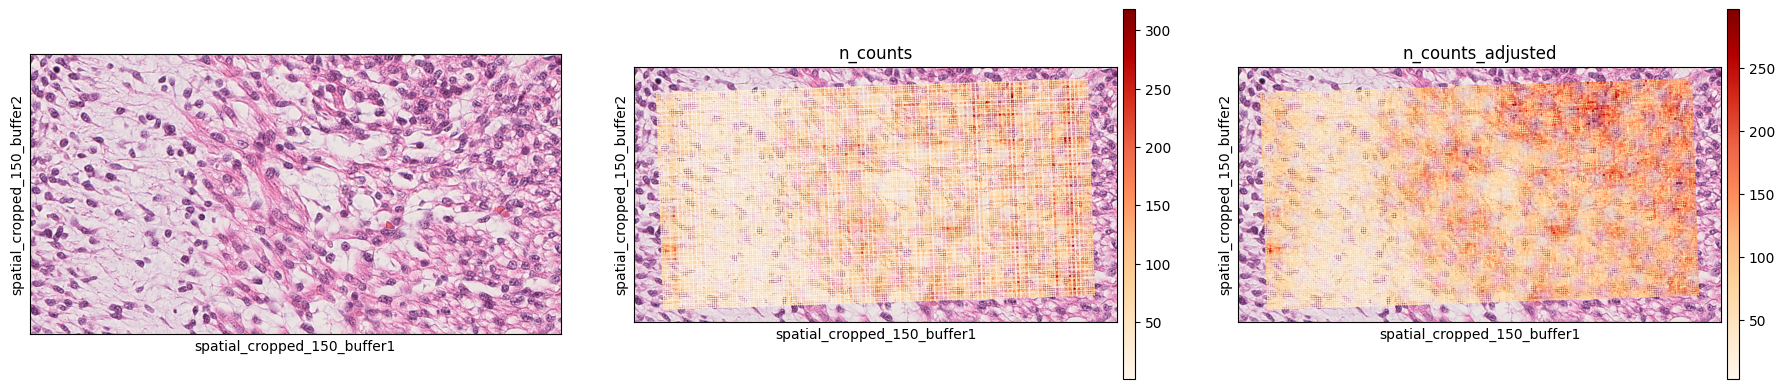

In [14]:
#define a mask to easily pull out this region of the object in the future
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )

bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")

In [15]:
sc.pl.spatial(adata,img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")


KeyboardInterrupt



In [16]:
adata.shape

(5001851, 18051)

# H&E segmentation

We will begin by performing H&E segmentation with StarDist's H&E model. This is likely to be the main segmentation used in analysis due to consistently picking out nuclei, getting reliable information on the location of cells in the data. It is recommended to lower the prob_thresh, making the model more lenient with regard to what it calls as nuclei - the default setting is quite stringent, while we want to seed a good number of putative cells in the object.

The segmentation results are turned to a sparse matrix and efficiently stored in an .npz file. If desired, they can be read via scipy.sparse.load_npz(), and the sparse matrix's dimensions will match those of the input image.

However, it is important to ensure that the gene expression bin grid is well aligned with the H&E image, or the mismatch will have bins loading segmentation results for sections of the tissue they are quite distant from. Visualising the total expression across parts of the tissue, similar to the plot made to show the "striped" effect earlier, is likely to be helpful in assessing the situation. In the event of a misalignment, the alignment can be corrected via 10X's loupe browser.

In [ ]:
prob_thresh_dict = {
    '0p01':0.01,
     '0p03':0.03,
    '0p05':0.05,
    '0p1':0.1,
}

for key,prob_thresh in prob_thresh_dict.items():
    print(f'### {key} ###')
    b2c.stardist(image_path="stardist/he.tiff", 
                 labels_npz_path=f"stardist/he_{key}.npz", 
                 stardist_model="2D_versatile_he", 
                 prob_thresh=prob_thresh
                )
    print('')

### 0p01 ###


2024-12-05 10:30:10.228900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 10:30:10.908609: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 10:30:11.205982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733394611.683311 2850957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733394611.753294 2850957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 10:30:12.674898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
# default setting
b2c.stardist(image_path="stardist/he.tiff", 
                 labels_npz_path=f"stardist/he_default.npz", 
                 stardist_model="2D_versatile_he", 
                 # prob_thresh=prob_thresh
                )

We can now load the resulting cell calls into the object. For any given bin, its corresponding pixel in the segmented image will be located and any potential label transferred over. It's important to inform b2c.insert_labels() of whether the segmented image was based on array (GEX visualisation of the grid) or spatial (rescaled H&E image) coordinates, which exact spatial representation matches the image, and what mpp was used.

In [ ]:
prob_thresh_dict = {
    '0p01':0.01,
     '0p03':0.03,
    '0p05':0.05,
    '0p1':0.1,
    'default':'default'
}

for key,prob_thresh in prob_thresh_dict.items():
    print(f'### {key} ###')
    b2c.insert_labels(adata, 
                  labels_npz_path=f"stardist/he_{key}.npz", 
                  basis="spatial", 
                  spatial_key="spatial_cropped",
                  mpp=mpp, 
                  labels_key=f"labels_he_{key}"
                 )

adata

Let's visualise the nuclear H&E segmentation on our selected region. The nuclei are identified successfully.

In [ ]:
mask = ((adata.obs['array_row'] >= 1050) & 
        (adata.obs['array_row'] <= 1100) & 
        (adata.obs['array_col'] >= 1100) & 
        (adata.obs['array_col'] <= 1150)
       )

bdata = adata[mask]

for key in prob_thresh_dict.keys():
    #0 means unassigned
    bdata = bdata[bdata.obs[f'labels_he_{key}']>0]
    bdata.obs[f'labels_he_{key}'] = bdata.obs[f'labels_he_{key}'].astype(str)
    print(len(set(bdata.obs[f'labels_he_{key}'])))
    sc.pl.spatial(bdata, color=[None,f'labels_he_{key}'], 
                  img_key="0.3_mpp", basis="spatial_cropped", legend_loc=None,
                  ncols=2
                 )